# Actividad 18 – MDS y PERMANOVA

En esta actividad exploramos los datos ambientales de la laguna de Términos utilizando clustering jerárquico, escalamiento multidimensional (MDS) y la prueba PERMANOVA.  
El objetivo es ver cómo los patrones de agrupación de las muestras pueden relacionarse con factores como la temporada o el estuario.  


In [2]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# PERMANOVA (requiere scikit-bio)
try:
    from skbio.stats.distance import DistanceMatrix, permanova
    SKBIO_AVAILABLE = True
except ImportError:
    SKBIO_AVAILABLE = False


In [3]:
# Funciones auxiliares
def preprocess_data(df, variables):
    df_clean = df.dropna(subset=variables)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean[variables])
    return df_clean, X_scaled

def perform_hierarchical_clustering(X_scaled, method="ward", n_clusters=3):
    linkage_matrix = linkage(X_scaled, method=method)
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion="maxclust")
    return linkage_matrix, cluster_labels

def plot_dendrogram(linkage_matrix, labels=None, n_clusters=3):
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix, labels=labels)
    plt.title(f"Dendrograma jerárquico (k={n_clusters})")
    plt.xlabel("Muestras")
    plt.ylabel("Distancia")
    plt.tight_layout()
    plt.show()


In [4]:
# Funciones para MDS
def compute_mds(X_scaled, metadata_df, n_components=2):
    dist_matrix = pairwise_distances(X_scaled, metric="euclidean")
    mds = MDS(n_components=n_components, dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_matrix)
    cols = [f"MDS{i+1}" for i in range(n_components)]
    mds_df = pd.DataFrame(coords, columns=cols, index=metadata_df.index)
    return dist_matrix, pd.concat([mds_df, metadata_df], axis=1)

def plot_mds_with_clusters(mds_df, label_col="sample"):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=mds_df, x="MDS1", y="MDS2",
                    hue="cluster", style="season", s=100)
    for _, row in mds_df.iterrows():
        plt.text(row["MDS1"], row["MDS2"], row[label_col], fontsize=7, alpha=0.6)
    plt.title("MDS 2D con clusters")
    plt.show()


In [5]:
# MDS en 3D
def plot_mds_3d(mds_df, label_col="sample"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(mds_df["MDS1"], mds_df["MDS2"], mds_df["MDS3"],
               c=mds_df["cluster"].astype(int), s=70, alpha=0.8)
    for _, row in mds_df.iterrows():
        ax.text(row["MDS1"], row["MDS2"], row["MDS3"], row[label_col], fontsize=6)
    ax.set_title("MDS 3D con clusters")
    plt.show()


In [6]:
# PERMANOVA
def run_permanova(dist_matrix, metadata_df, group_col, permutations=999):
    if not SKBIO_AVAILABLE:
        raise ImportError("scikit-bio es requerido para PERMANOVA")
    dist_matrix = (dist_matrix + dist_matrix.T) / 2
    np.fill_diagonal(dist_matrix, 0)
    dm = DistanceMatrix(dist_matrix, ids=metadata_df.index.astype(str).tolist(), validate=False)
    grouping = metadata_df[group_col].tolist()
    return permanova(dm, grouping, permutations=permutations)


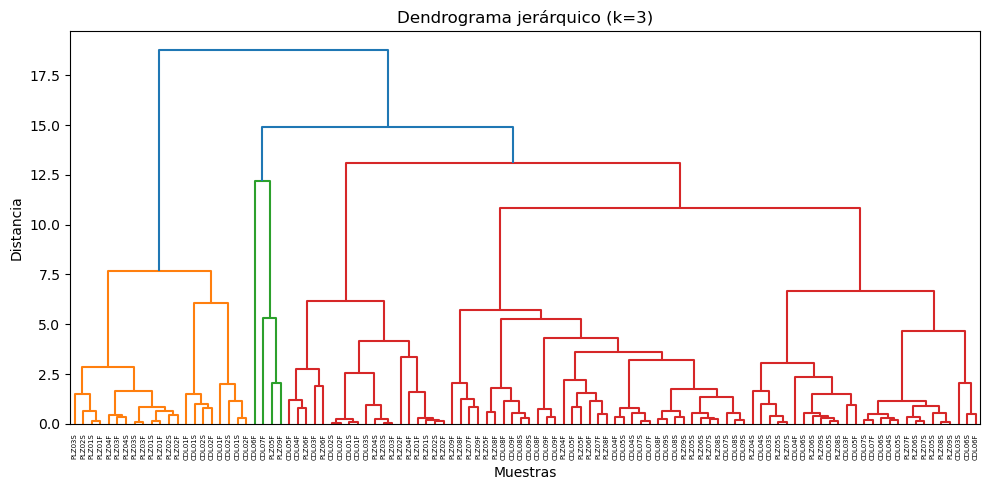

In [7]:
#  Flujo principal 
data_path = "../data/Terminos_lagoon_TA_DIC_2023_RawData.csv"
df = pd.read_csv(data_path)

# Variables ambientales
selected_vars = ["dic_micromol_kg", "ta_micromol_kg", "sal_psu",
                 "temp_c", "do_mg_l", "chlorophy_microg_l", "turbidity_fnu"]

df_clean, X_scaled = preprocess_data(df, selected_vars)

# Clustering
Z, clusters = perform_hierarchical_clustering(X_scaled, n_clusters=3)
df_clean["cluster"] = clusters
plot_dendrogram(Z, labels=df_clean["sample"].values, n_clusters=3)


/Users/adua/miniconda3/envs/environmental_python/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


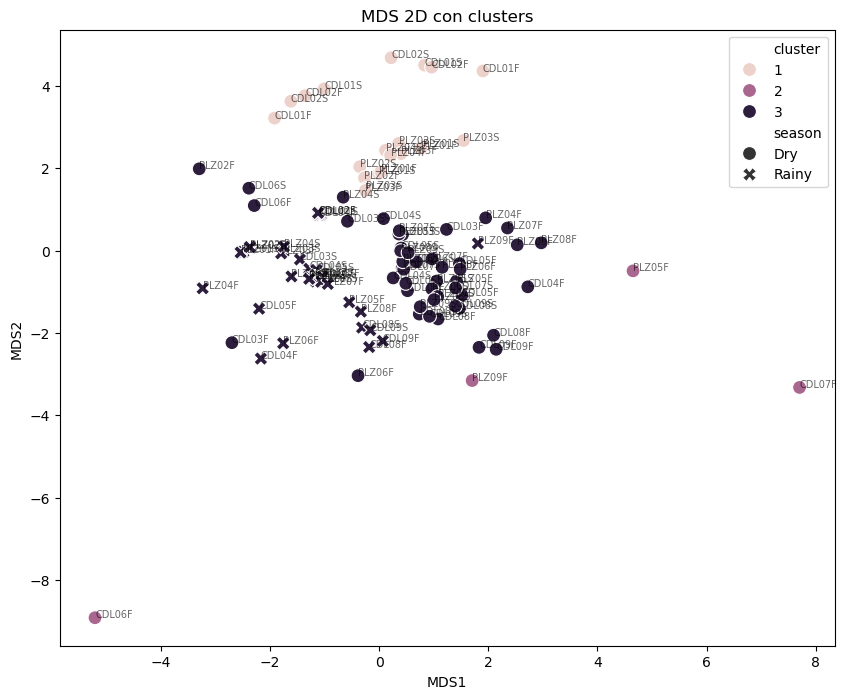

In [8]:
# MDS 2D
dist2d, mds2_df = compute_mds(X_scaled, df_clean[["season", "estuary", "sample", "cluster"]], n_components=2)
plot_mds_with_clusters(mds2_df)


/Users/adua/miniconda3/envs/environmental_python/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


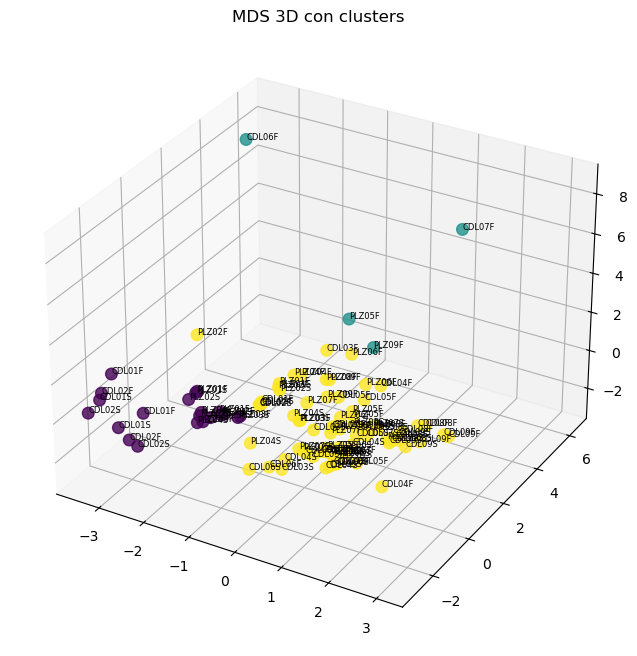

In [9]:
# MDS 3D
dist3d, mds3_df = compute_mds(X_scaled, df_clean[["season", "estuary", "sample", "cluster"]], n_components=3)
plot_mds_3d(mds3_df)


In [10]:
# PERMANOVA entre clusters
if SKBIO_AVAILABLE:
    result = run_permanova(dist2d, mds2_df, group_col="cluster")
    print("Resultados PERMANOVA:")
    print(result)
else:
    print("⚠️ scikit-bio no está instalado, no se puede correr PERMANOVA.")


Resultados PERMANOVA:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     106
number of groups                  3
test statistic            32.544739
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


### Conclusión
Este ejercicio me permitió integrar varias técnicas: clustering jerárquico, MDS (2D y 3D) y PERMANOVA.  
Lo interesante es cómo los clusters sugieren cierta estructura en los datos, y el MDS lo hace visualmente más claro.  
PERMANOVA es útil para comprobar si las diferencias entre grupos son estadísticamente significativas, aunque siempre hay que recordar que depende de la métrica de distancia elegida y del número de permutaciones.  
